## Simple Artificial Neural Network (ANN) with Titanic Dataset

An Artificial Neural Network (ANN) in simple terms is a computational model inspired by the way the human brain works. It consists of interconnected neurons, forming a network. The architecture of an ANN builds layers sequentially, with each neuron in a layer connected to every neuron in the previous layer. The structure includes:

1. Input Layer
2. Hidden Layer(s) (one or more layers)
3. Output Layer

Lets check out the detailed EDA and different Model and how the predictions and accuracy varies based on our input dimensions

In [310]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import  LabelEncoder,StandardScaler,Normalizer, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
import tensorflow as tf

### Read and check basic information

In [311]:
df = pd.read_csv('.././csv/titantic.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Description
| Variable | Description | Key |
| :- | -: | :-: |
| survival | Survival	 | 0 = No, 1 = Yes
| pclass| Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd
| sex	|Sex	
| Age	| Age  in years	
| sibsp	|# of siblings / spouses aboard the Titanic	
| parch	|# of parents / children aboard the Titanic	
| ticket	|Ticket number	
| fare	|Passenger fare	
| cabin	|Cabin number	
| embarked |Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Check for Null and Duplicate values

In [313]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [314]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [315]:
df.duplicated().sum()

0

### Dropping columns
1. Passenger ID, Name Column as its not required for our modeling
2. Cabin column has lot of NULL values therefore wont be helpful for making predictions

In [316]:
df.drop(labels=['PassengerId','Name','Cabin','Ticket'],inplace=True,axis=1)

#### We can fill Mean or Median for age columns but for now parking it

In [317]:
#Checking the % of Null values: As its only 19% we can ignore for now lets see later
pct_age_null = (df['Age'].isna().sum()/df.shape[0])  
pct_embarked_null = (df['Embarked'].isna().sum()/df.shape[0]) 
print(f'Percentage of Nulls in Age column :{pct_age_null:.2%}')
print(f'Percentage of Nulls in Embarked column :{pct_embarked_null:.2%}')

Percentage of Nulls in Age column :19.87%
Percentage of Nulls in Embarked column :0.22%


In [318]:
#df['Age'].fillna(df['Age'].median(),inplace=True)

#### As Embarked Null % is very low, dropping the rows

In [319]:
df.dropna(subset=['Embarked'], how='all',inplace=True)

In [320]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

#### Checking Class imbalance: 60% & 40% is fine though imbalanced , we can proceed

In [321]:
(df['Survived'].value_counts()/df.shape[0]) * 100

Survived
0    61.754781
1    38.245219
Name: count, dtype: float64

### Univariate Analysis

<Axes: >

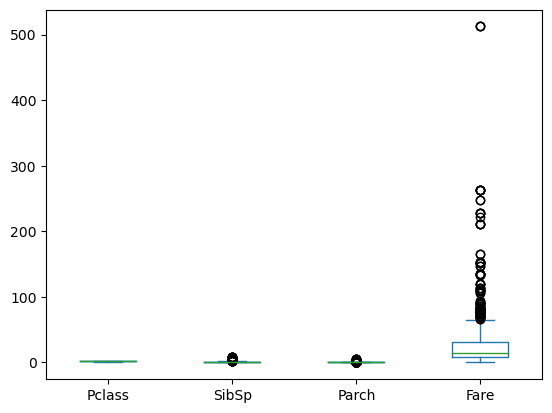

In [322]:
# Check for outliers
df[['Pclass','SibSp', 'Parch','Fare']].plot(kind='box')

In [323]:
# Outlier evaluation: As the % is less, we are ignoring the outliers as well
outlier_cols = ['Pclass','SibSp', 'Parch','Fare']
for col in outlier_cols:
    q1,q3 = df[col].quantile([.25,.75])    
    iqr = q3 - q1
    lf = q1 - (1.5 * iqr)
    uf = q3 + (1.5 * iqr)    
    lf_pct = (df[(df[col]< lf)][col].count()/df.shape[0])
    uf_pct = (df[(df[col]> uf)][col].count()/df.shape[0])
    print(f"The % of outliers in {col} = {lf_pct:.2%},{uf_pct:.2%}")

The % of outliers in Pclass = 0.00%,0.00%
The % of outliers in SibSp = 0.00%,5.17%
The % of outliers in Parch = 0.00%,23.96%
The % of outliers in Fare = 0.00%,12.82%


#### Visually Check Distribution of numeric features: Columns 'SibSp', 'Parch','Fare' are positively skewed

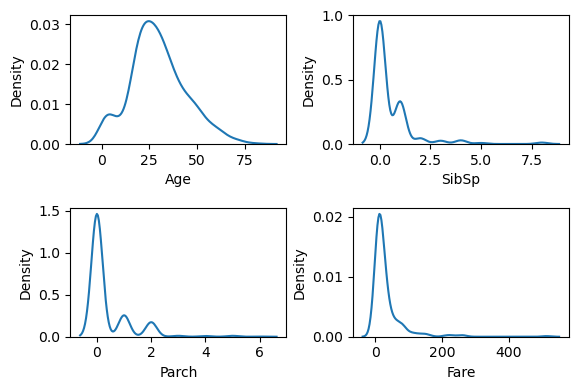

In [324]:
numeric_cols = [  'Age', 'SibSp', 'Parch','Fare']
fig, ax= plt.subplots(nrows =2,ncols=2,figsize = (6,4))
j = 0
k = 0
for i,col in enumerate(numeric_cols): 
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:        
        j = j + 1
        k = 0
    else: 
        k = k + 1        
    fig.tight_layout()
    ax[j,k].set_xlabel(col)
    sns.kdeplot(data=df[col],x=(df[col]),ax=ax[j,k])    

#### Lets apply transformation and check if we are able to achieve normal distribution

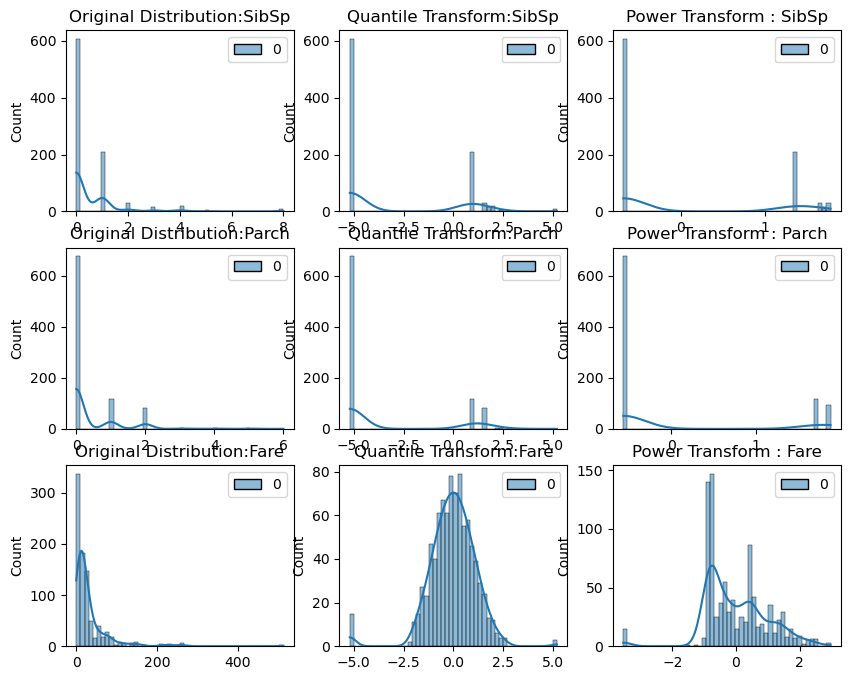

In [325]:
pt = PowerTransformer()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
numeric_cols = [  'SibSp', 'Parch','Fare']
fig, ax= plt.subplots(nrows =2,ncols=2,figsize = (10,8))
j = 1
for col in numeric_cols:
    data = np.array(df[col]).reshape(-1, 1)
    y = pt.fit_transform(data)
    x = qt.fit_transform(data)
    plt.subplot(3,3,j)
    sns.histplot(data, bins = 50, kde = True)
    plt.title(f"Original Distribution:{col}")
    plt.subplot(3,3,j+1)
    sns.histplot(x, bins = 50, kde = True)
    plt.title(f"Quantile Transform:{col}")
    plt.subplot(3,3,j+2)
    sns.histplot(y, bins = 50, kde = True)
    plt.title(f"Power Transform : {col}")
    j += 3
    fig.show()


#### Apply Quantile Transform for Fare as 'SibSp', 'Parch' is not tranforming we will park it for now  

In [326]:
data = np.array(df['Fare']).reshape(-1, 1)
df['fare_transformed']  = pt.fit_transform(data)

### Bivariate Analysis

In [327]:
color_scales =['Blackbody', 'Bluered','Blues','Earth','Electric','Greens','Greys',
'Hot','Jet','Picnic','Portland','Rainbow','RdBu','Reds','Viridis','YlGnBu','YlOrRd'] #16

In [328]:
df_class = df[['Pclass','Survived']].groupby(['Pclass','Survived']).agg({'Pclass':'count'})
df_class = df_class.rename(columns={'Pclass':'count'}).reset_index()
df_class

,Pclass,Survived,count
0,1,0,80
1,1,1,134
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


In [329]:
fig = px.bar(df_class, x= 'Pclass',y='count',color='Survived',color_continuous_scale=color_scales[5])
fig.update_layout(height=400,width=700,title='Survival based on Class')

In [330]:
df_sex = df[['Survived','Sex']].groupby(['Survived','Sex']).agg({'Sex':'count'})
df_sex = df_sex.rename(columns={'Sex':'count'}).reset_index()
df_sex

,Survived,Sex,count
0,0,female,81
1,0,male,468
2,1,female,231
3,1,male,109


In [331]:
fig = px.bar(df_sex,x='Sex',y='count',color='Survived',color_continuous_scale=color_scales[3])
fig.update_layout(height=400,width=600,title='Survival based on Gender')

In [332]:
def grp_age(x):
    if x < 5:
        grp = 'Toddler'
    elif x >= 5 and x < 12:
        grp = 'Child'
    elif x >= 12 and x < 18:
        grp = 'Youth'
    else:
        grp = 'Adult'
    return grp

df['Age_Category'] = df['Age'].apply(grp_age)

In [333]:
df_age = df[['Age_Category','Survived']].groupby(['Age_Category','Survived']).agg({'Survived':'count'})
df_age = df_age.rename(columns={'Survived':'count'}).reset_index()
df_age

,Age_Category,Survived,count
0,Adult,0,497
1,Adult,1,279
2,Child,0,16
3,Child,1,12
4,Toddler,0,13
5,Toddler,1,27
6,Youth,0,23
7,Youth,1,22


In [334]:
fig = px.bar(df_age, x='Age_Category', y='count', color='Survived', color_continuous_scale=color_scales[0])
fig.update_layout(height=400,width=700,title='Survival based on Age Category')

## Mulivariate Analysis

#### Encode the categorical variables

In [335]:
encoder = LabelEncoder()
for col in ['Sex','Embarked']:
    df[col] = encoder.fit_transform(df[col])

In [336]:
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,fare_transformed,Age_Category
0,0,3,1,22.0,1,0,7.2500,2,-0.876580,Adult
1,1,1,0,38.0,1,0,71.2833,0,1.341242,Adult
2,1,3,0,26.0,0,0,7.9250,2,-0.787660,Adult
3,1,1,0,35.0,1,0,53.1000,2,1.071865,Adult
4,0,3,1,35.0,0,0,8.0500,2,-0.772006,Adult


#### Check for Multicollinearity

<Axes: >

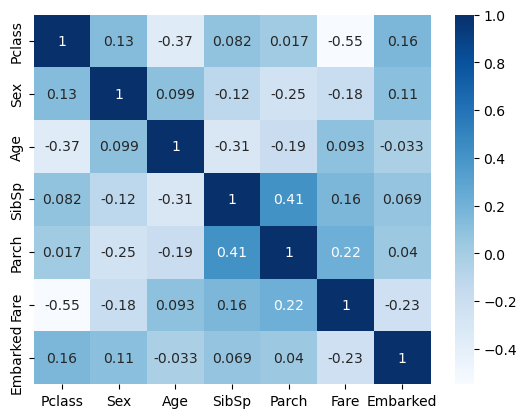

In [337]:
corr_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',  'Fare','Embarked'] 
sns.heatmap(data=df[corr_cols].corr(),annot=True,cmap='Blues')

#### Pair Plot

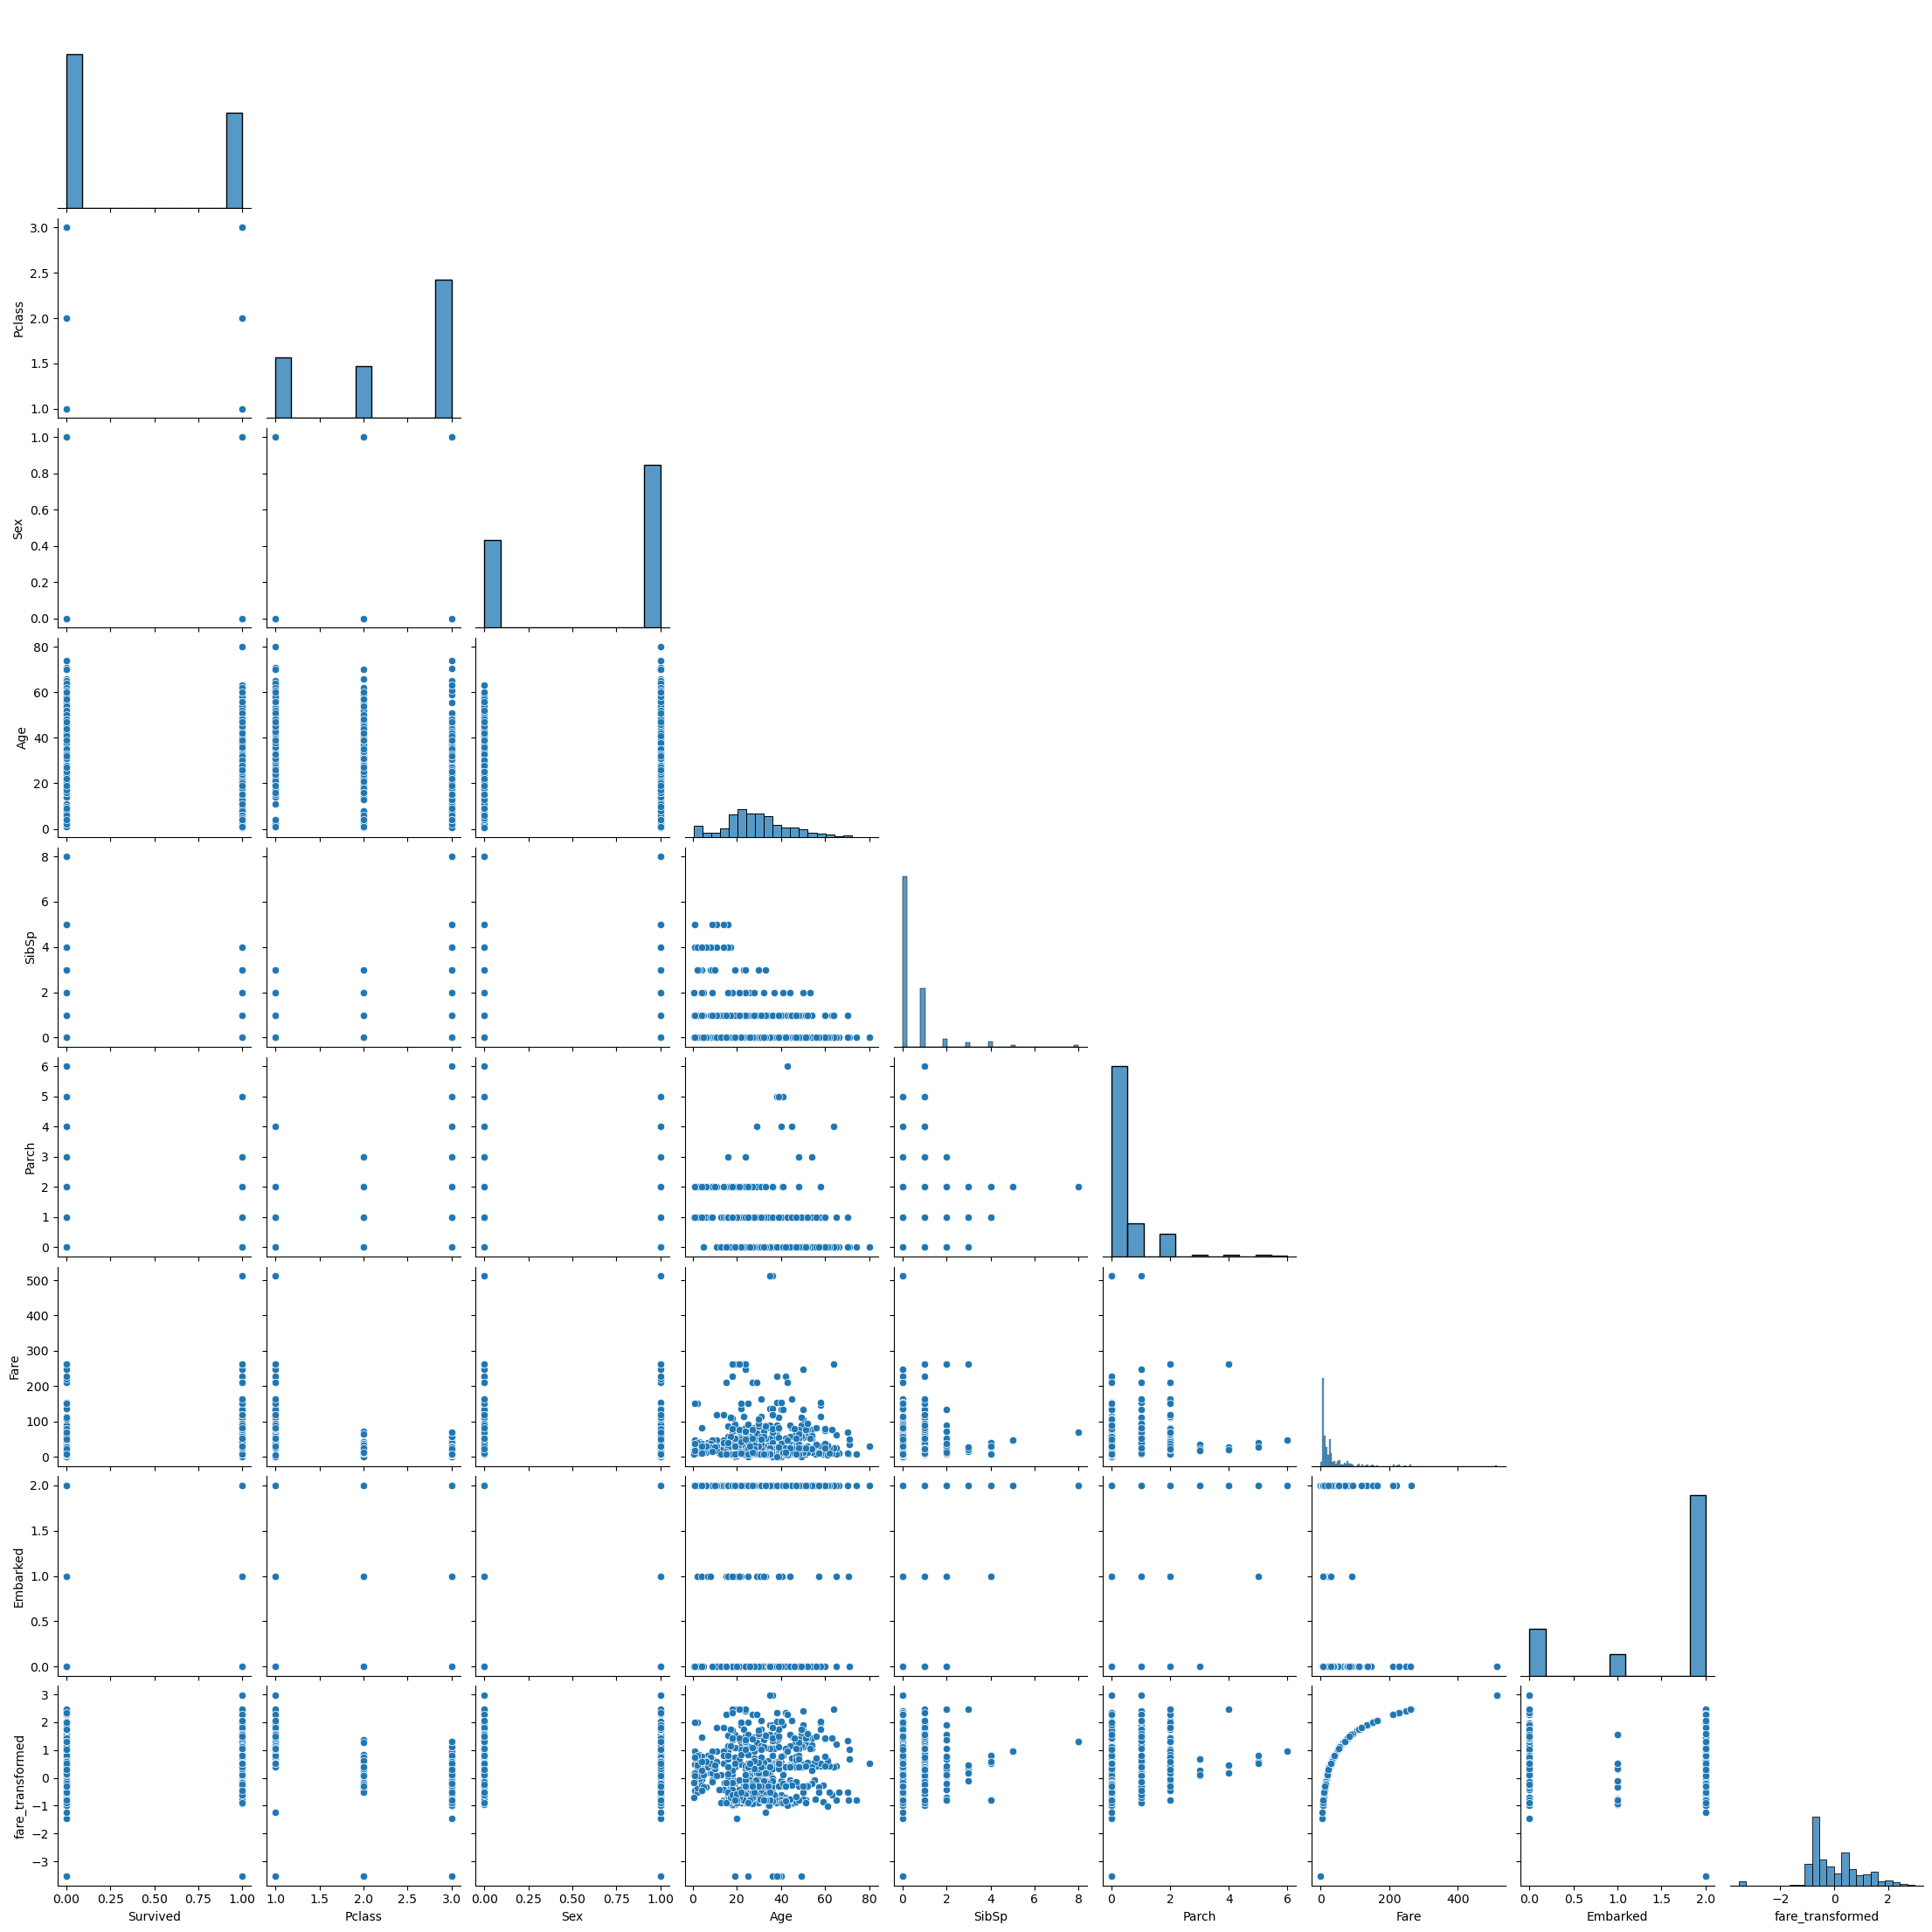

In [338]:
sns.pairplot(df,corner=True)

### Model Building

### Predict Age using Linear Regression model

In [339]:
train_data = df.loc[(df.Age.notnull())]  
test_data = df.loc[(df.Age.isnull())]  
x = train_data.values[:, [0,1, 2]] # taking only Survived,Pclass,Sex as inputs
y = train_data.values[:, 3] # age is our y

In [340]:
lr_model = LinearRegression()
lr_model.fit(x,y)
predict_age = lr_model.predict(test_data.values[:, [0,1, 2]])
df['pred_age'] = df.Age
df.loc[(df.pred_age.isnull()), 'pred_age'] = predict_age 

## Model 1
    - Basic model with no scaling or transformation

#### Logistic Regression

In [341]:
x = df[['Pclass', 'Sex', 'pred_age', 'SibSp', 'Parch',  'Fare','Embarked']]
y = df['Survived']

In [342]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [343]:
base_lg_model = LogisticRegression()
base_lg_model.fit(X_train,y_train)
y_pred = base_lg_model.predict(X_test)

In [344]:
accuracy_score(y_test,y_pred)

0.8146067415730337

In [345]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       109
           1       0.74      0.81      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.82       178



#### Decision Tree

In [346]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8033707865168539

#### Random Forest

In [347]:
dt_model = RandomForestClassifier(n_estimators=100,random_state=42)
dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7921348314606742

#### ANN - Sequential

In [348]:
ann_seq_model = Sequential(
[
    layers.Dense(10,activation='relu',name = 'layer1'), #input Layer
    layers.Dense(10,activation='relu',name = 'layer2'),
    layers.Dense(10,activation='relu',name = 'layer3'),
    layers.Dense(1,activation='sigmoid',name='layer4') # output layer
    
])

In [349]:
ann_seq_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Loss Function
1. For Regression:
      - Mean Squared Error (MSE) :This is the most common loss function for regression problems. 
        It calculates the average squared difference between the predicted and actual values.
      - Mean Absolute Error (MAE):This loss function calculates the average absolute difference 
        between the predicted and actual values. It is less sensitive to outliers compared to MSE.
2. For Binary Classification:
      - Binary Crossentropy :This is the go-to loss function for binary classification problems. 
        It measures the dissimilarity between the predicted probabilities and the true labels (0 or 1).
3. For Multi-Class Classification:
      - Categorical Crossentropy : Use this loss function when you have multiple classes and your labels are one-hot encoded.
      - Sparse Categorical Crossentropy: Use this loss function when you have multiple classes 
        and your labels are integers (not one-hot encoded).

In [350]:
ann_seq_model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(),metrics = [tf.keras.metrics.BinaryAccuracy()])

In [351]:
ann_seq_model.fit(X_train,y_train,epochs=10)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.3950 - loss: 0.9648
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6046 - loss: 0.6871 
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6996 - loss: 0.5922 
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6735 - loss: 0.5867 
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6764 - loss: 0.6144 
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6642 - loss: 0.6080 
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6867 - loss: 0.5970 
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6958 - loss: 0.5640 
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7064 - loss: 0.5763 
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7040 - loss: 0.5667 


In [352]:
#Model Evaluation
loss,accuracy = ann_seq_model.evaluate(X_test,y_test)
loss,accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7311 - loss: 0.5513  


(0.5712988376617432, 0.7022472023963928)

#### Prediction
The output format for predictions is an array of probabilities. Each entry in this array represents the predicted probability that the corresponding instance in the test set belongs to the positive class (in this case, survived). Since the final layer of the model uses a sigmoid activation function, the output probabilities are between 0 and 1.Each value is a probability indicating how likely it is that the passenger survived (1 for survived, 0 for not survived).

To convert these probabilities to binary class predictions, you typically use a threshold of 0.5, meaning probabilities greater than 0.5 are classified as 1 (survived), and those less than or equal to 0.5 are classified as 0 (not survived)

In [388]:
#Prediction
predictions = ann_seq_model.predict(X_test)
y_pred =  (predictions > 0.5).astype(int)
print('Example for first row:')
print('Test row:',y_test[:1])
print('Predicted classif > 0.5 then 1 else 0:',y_pred[:1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Example for first row:
Test row: 281    0
Name: Survived, dtype: int64
Predicted classif > 0.5 then 1 else 0: [[0]]


In [ ]:
accuracy_score(y_test,y_pred)

## Model 2
    - Model with Standard Scalrer and normaly distributed Fare feature

#### Logistic Regression

In [354]:
x = df[['Pclass', 'Sex', 'pred_age', 'SibSp', 'Parch',  'fare_transformed','Embarked']]
y = df['Survived']

In [355]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [356]:
scalar = StandardScaler()
x_train_scaled = scalar.fit_transform(X_train)
x_test_scaled = scalar.transform(X_test)

In [357]:
base_lg_model = LogisticRegression()
base_lg_model.fit(x_train_scaled,y_train)
y_pred = base_lg_model.predict(x_test_scaled)

In [358]:
accuracy_score(y_test,y_pred)

0.8202247191011236

In [359]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       109
           1       0.75      0.81      0.78        69

    accuracy                           0.82       178
   macro avg       0.81      0.82      0.81       178
weighted avg       0.82      0.82      0.82       178



#### Decision Tree

In [360]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_scaled,y_train)
y_pred = dt_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.8033707865168539

#### Random Forest

In [361]:
dt_model = RandomForestClassifier(n_estimators=100,random_state=42)
dt_model.fit(x_train_scaled,y_train)
y_pred = dt_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7921348314606742

#### ANN - Sequential

In [362]:
ann_seq_model = Sequential(
[
    layers.Dense(10,activation='relu',name = 'layer1',input_dim=7),
    layers.Dense(10,activation='relu',name = 'layer2'),
    layers.Dense(10,activation='relu',name = 'layer3'),
    layers.Dense(1,activation='sigmoid',name='layer4') 
    
])

In [363]:
ann_seq_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 10)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311 (1.21 KB)

 Trainable params: 311 (1.21 KB)

 Non-trainable params: 0 (0.00 B)

In [364]:
ann_seq_model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(),metrics = [tf.keras.metrics.BinaryAccuracy()])

In [365]:
ann_seq_model.fit(x_train_scaled,y_train,epochs=10)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.5643 - loss: 0.7101
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5928 - loss: 0.6851 
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6322 - loss: 0.6589 
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6385 - loss: 0.6318 
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6176 - loss: 0.6268  
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6158 - loss: 0.6135 
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6304 - loss: 0.5942 
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6646 - loss: 0.5710 
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6447 - loss: 0.5776 
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6579 - loss: 0.5541 


In [366]:
#Model Evaluation
loss,accuracy = ann_seq_model.evaluate(x_test_scaled,y_test)
loss,accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7223 - loss: 0.5195 


(0.5457713007926941, 0.7078651785850525)

In [387]:
#Prediction
predictions = ann_seq_model.predict(x_test_scaled)
y_pred = (predictions > 0.5).astype(int)
accuracy_score(y_test ,y_pred )

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Example for first row:
Test row: 281    0
Name: Survived, dtype: int64
Predicted classif > 0.5 then 1 else 0: [[0]]


## Model 3
     - Model with features scaled and transformed
     - Taking average of Sibilings and parents and merging into single column
     - ANN with 32 Neurons

#### Logistic Regression

In [368]:
df['sib_p_avg'] = df[['SibSp', 'Parch']].mean(axis=1)

In [369]:
x = df[['Pclass', 'Sex', 'pred_age', 'sib_p_avg', 'fare_transformed','Embarked']]
y = df['Survived']

In [370]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [371]:
scalar = StandardScaler()
x_train_scaled = scalar.fit_transform(X_train)
x_test_scaled = scalar.transform(X_test)

In [372]:
base_lg_model = LogisticRegression()
base_lg_model.fit(x_train_scaled,y_train)
y_pred = base_lg_model.predict(x_test_scaled)

In [373]:
accuracy_score(y_test,y_pred)

0.8202247191011236

In [374]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       109
           1       0.75      0.80      0.77        69

    accuracy                           0.82       178
   macro avg       0.81      0.82      0.81       178
weighted avg       0.82      0.82      0.82       178



#### Decision Tree

In [375]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_scaled,y_train)
y_pred = dt_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.797752808988764

#### Random Forest

In [376]:
dt_model = RandomForestClassifier(n_estimators=100,random_state=42)
dt_model.fit(x_train_scaled,y_train)
y_pred = dt_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7865168539325843

#### ANN - Sequential

In [377]:
ann_seq_model = Sequential(
[
    layers.Dense(32,activation='relu',name = 'layer1',input_dim=6),
    layers.Dense(32,activation='relu',name = 'layer2'),
    layers.Dense(32,activation='relu',name = 'layer3'),
    layers.Dense(32,activation='relu',name = 'layer4'),
    layers.Dense(1,activation='sigmoid',name='layer5') 
    
])

In [378]:
ann_seq_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer5 (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,425 (13.38 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 0 (0.00 B)

In [432]:
adam_optimizer = tf.keras.optimizers.Adam()
ann_seq_model.compile(optimizer= adam_optimizer ,loss= tf.keras.losses.BinaryCrossentropy(),metrics = [tf.keras.metrics.BinaryAccuracy()])

In [380]:
ann_seq_model.fit(x_train_scaled,y_train,epochs=30,batch_size = 100)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.6349 - loss: 0.6612
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6383 - loss: 0.6216 
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7395 - loss: 0.5832 
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7986 - loss: 0.5512 
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7805 - loss: 0.5183 
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8093 - loss: 0.4744 
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8162 - loss: 0.4600 
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8076 - loss: 0.4423 
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8235 - loss: 0.4207 
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.8392 - loss: 0.3980
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8411 - loss: 0.4110 
Epoch 12/

In [381]:
#Model Evaluation
loss,accuracy = ann_seq_model.evaluate(x_test_scaled,y_test)
loss,accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8572 - loss: 0.4088  


(0.4832252860069275, 0.8146067261695862)

In [382]:
#Prediction
predictions = ann_seq_model.predict(x_test_scaled)
y_pred = (predictions > 0.5).astype(int)
accuracy_score(y_test ,y_pred )

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


0.8146067415730337

#### Learning Rate

In [434]:
print(adam_optimizer.learning_rate.numpy())

0.001


#### Visualize for different Learning Rate

In [400]:
learning_rate = [0.001,0.002,0.003,0.01,0.02,0.03]
loss = []
for rate in learning_rate:
    ann_seq_model = Sequential(
    [
        layers.Dense(32,activation='relu',name = 'layer1',input_dim=6),
        layers.Dense(32,activation='relu',name = 'layer2'),
        layers.Dense(32,activation='relu',name = 'layer3'),
        layers.Dense(32,activation='relu',name = 'layer4'),
        layers.Dense(1,activation='sigmoid',name='layer5') 

    ])  

    optimizer = tf.keras.optimizers.Adam(learning_rate=rate)
    ann_seq_model.compile(optimizer=optimizer,loss= tf.keras.losses.BinaryCrossentropy(),
                          metrics = [tf.keras.metrics.BinaryAccuracy()])
    history  = ann_seq_model.fit(x_train_scaled,y_train,epochs=30,batch_size = 100)
    loss.append(history.history ['loss'][-1])
    #print(learning_data)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.6745 - loss: 0.6733
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7483 - loss: 0.6314 
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7686 - loss: 0.5892 
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7961 - loss: 0.5472 
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8176 - loss: 0.5023 
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8297 - loss: 0.4608 
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8154 - loss: 0.4454 
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8009 - loss: 0.4468 
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7972 - loss: 0.4232 
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8111 - loss: 0.4130 
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8179 - loss: 0.3980 
Epoch 12/

In [417]:
#Visualize Learning Rate
fig =px.scatter(x=learning_rate,y=loss,title='Learning Rate: At 0.01 the Loss is minimum') 
fig.update_traces(mode='lines+markers',line=dict(color='orange'),marker=dict(color='red'))
fig.update_layout(xaxis_title='Learning Rate',yaxis_title='Loss',width=700, height=500,plot_bgcolor = 'lightblue')

## Thank you for reaching here!